Computational Photography, ELEC 549, Fall 2023, Rice University,

Instructor: Ashok Veeraraghavan,

Authors: Sean Farrell, Aniket Dashpute


# Multi-image denoising with motion
In this section of the homework, the goal is to perform multi-image denoising by correcting for motion artifacts between sequential frames. Motion between frames is estimated using the Lucas Kanade algroithm.
1. First register images on clean image stack and show that motion artifacts are minimized
2. Perform registeration on noisy image stack
3. Implemnent static multi-imaging denoising techniques developed in HW1 part 1

In [2]:
# mount drive
from google.colab import drive, files
drive.mount('/content/drive/')

Mounted at /content/drive/


In [3]:
# move to ashok hw directory
%cd drive/MyDrive/Ashok_Hw1_Part2_Data

/content/drive/MyDrive/Ashok_Hw1_Part2_Data


**Note:**
1. Make sure the required data is loaded into the workspace.
2. Remember to first make your own copy of this notebook, if you make changes here directly, they might not be saved
----

In [4]:
# Import necessary packages
import numpy as np
import os
import cv2
import sys
from scipy.fftpack import dct, idct
import matplotlib.pyplot as plt
from skimage.transform import warp
import scipy
import pywt
import copy
from scipy import ndimage
from scipy.signal import fftconvolve

Helper functions

In [5]:
def normalize_2D(x):
  '''
  This function normalizes a 2D image between 0 and 1
  '''
  return (x-np.min(x))/(np.max(x)-np.min(x))

def psnr(ref,x):
  '''
  This function computes the peak-signal-to-noise-ratio
  between two images in decibles (dB).
  '''
  if ref.size != x.size:
    print('ERROR: two images should be the same size to compute psnr.\n')
    sys.exit()
  ref = ref.astype(np.float64)
  x = x.astype(np.float64)
  RMSE = np.sqrt(np.sum((ref-x)**2)/ref.size)

  return 20*np.log10(np.max(ref)/RMSE)

In [6]:
!pwd

/content/drive/MyDrive/Ashok_Hw1_Part2_Data


# Load in the clean image stack

In [7]:
Z = np.load("clean_img_stack.npy")
print(Z.shape)

(21, 1024, 1024)


# Initial motion artifacts
Here we wil define three cropped regions of interest that we will analyze throughout the homework

In [8]:
crop1 = np.array([300,500,425,625])     # lime
crop2 = np.array([450,650,700,900])    # baseball
crop3 = np.array([300,500,25,225])       # elephant

Text(0.5, 1.0, 'Scene Motion - Clean')

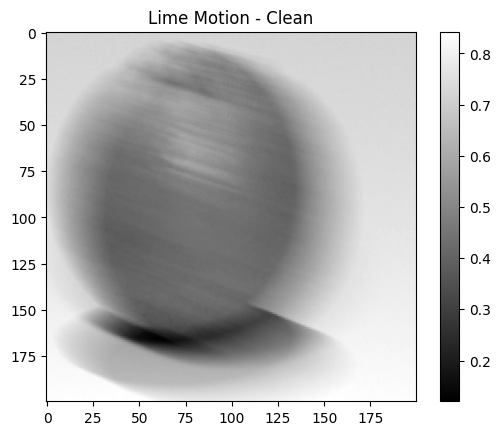

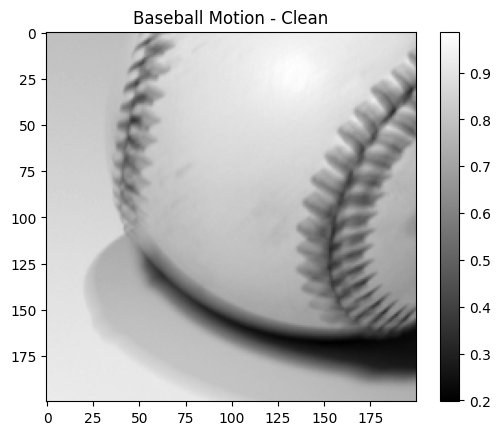

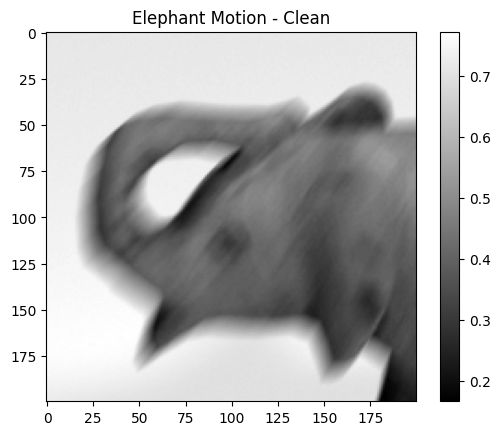

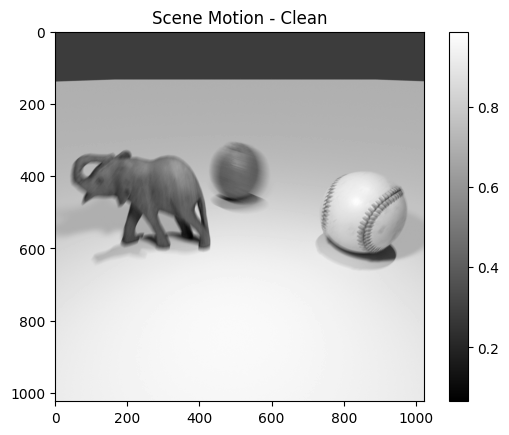

In [9]:
# Show an average over all frames in clean image stack

Z_crop1 = Z[:,crop1[0]:crop1[1],crop1[2]:crop1[3]]
Z_crop2 = Z[:,crop2[0]:crop2[1],crop2[2]:crop2[3]]
Z_crop3 = Z[:,crop3[0]:crop3[1],crop3[2]:crop3[3]]
'''
TODO:
Compute and display averaged image for Z_crop1, Z_crop2,
Z_crop3, and complete image Z_averaged
'''

Z_crop1_averaged = np.mean(Z_crop1, axis=0)
plt.figure()
plt.imshow(Z_crop1_averaged, cmap='gray')
plt.colorbar()
plt.title('Lime Motion - Clean')

Z_crop2_averaged = np.mean(Z_crop2, axis=0)
plt.figure()
plt.imshow(Z_crop2_averaged, cmap='gray')
plt.colorbar()
plt.title('Baseball Motion - Clean')

Z_crop3_averaged = np.mean(Z_crop3, axis=0)
plt.figure()
plt.imshow(Z_crop3_averaged, cmap='gray')
plt.colorbar()
plt.title('Elephant Motion - Clean')

Z_averaged = np.mean(Z, axis=0)
plt.figure()
plt.imshow(Z_averaged, cmap='gray')
plt.colorbar()
plt.title('Scene Motion - Clean')

# Clean Image Registration
In this section you will take the clean image stack and estimate the motion between images using optical flow. You be tasked with implementing your own Lucas Kanade optical flow algorithm.

In [10]:
# def get_derivatives(A):
#   Ax = cv2.Sobel(A, cv2.CV_64F, 1, 0, ksize=3)
#   Ay = cv2.Sobel(A, cv2.CV_64F, 0, 1, ksize=3)

#   # Ax = cv2.filter2D(A, -1, kernsize)
#   # Ay = cv2.filter2D(A, -1, kernsize)
#   return Ax, Ay


def get_derivatives(A):
  kernel_x = np.array([[0, 0, 0],[0, -1.0, 1.0],[0, 0, 0]], dtype='float')
  kernel_y = np.array([[0, 0, 0],[0, -1.0, 0],[0, 1.0, 0]], dtype='float')
  Ax = cv2.filter2D(A, ddepth=-1, kernel=kernel_x)
  Ay = cv2.filter2D(A, ddepth=-1, kernel=kernel_y)
  return Ax, Ay

In [13]:
# '''
# debug version
# TODO:
# Estimate the motion to go from the frame to the reference frame
# '''
# def kl_optical_flow(ref_frame, frame, window_size):
#   # implement the matrix solution detailed in the assignment description
#   # frame is current frame, ref_frame is next frame, with all the deltas added
#   # print(frame.shape)
#   u = np.zeros(frame.shape)
#   v = np.zeros(frame.shape)
#   I_t = frame - ref_frame
#   I_x, I_y = get_derivatives(frame) # fix this to get basic kernel
#   # solve - uˆ = ((A⊤A)^−1)A⊤b
#   # shape matrix
#   for yc in range(frame.shape[0]):
#     for xc in range(frame.shape[1]):
#       # let window size be total kernel size
#       #for pix in range(-window_size//2, (window_size-1)//2):
#       min_y = max(0, yc-window_size//2)
#       min_x = max(0, xc-window_size//2)
#       max_y = min(yc+(window_size-1)//2+1, frame.shape[0])
#       max_x = min(xc+(window_size-1)//2+1, frame.shape[1])
#       # print("stats", min_y, max_y, min_x, max_x, yc-window_size//2, yc+(window_size-1)//2+1)
#       I_x_sub = I_x[min_y:max_y, min_x:max_x]
#       I_y_sub = I_y[min_y:max_y, min_x:max_x]
#       I_t_sub = I_t[min_y:max_y, min_x:max_x]
#       # print("subs", I_x_sub.shape, I_y_sub.shape, I_t_sub.shape)
#       # print("it sub", I_t_sub)
#       # print("it shape", I_t.shape)
#       A = np.vstack((I_x_sub.flatten(), I_y_sub.flatten())).T
#       b = 1*I_t_sub.flatten().T
#       # print("ycxc ashape bshape", yc, xc, A.shape, b.shape)
#       # print(A, b)
#       uhat = np.linalg.lstsq(A, b)[3]#np.linalg.inv(A.T@A)@(A.T)@b
#       # print(uhat)
#       u_temp, v_temp = uhat[0], uhat[1]
#       u[yc][xc] = u_temp
#       v[yc][xc] = v_temp
#   return u, v # per image #


'''
TODO:
Estimate the motion to go from the frame to the reference frame
'''
def kl_optical_flow(ref_frame, frame, window_size):
  # implement the matrix solution detailed in the assignment description
  # frame is current frame, ref_frame is next frame, with all the deltas added
  # print(frame.shape)
  h, w = frame.shape
  half_window = window_size//2

  u = np.zeros_like(frame)
  v = np.zeros_like(frame)

  Ix = np.gradient(frame, axis = 0)
  Iy = np.gradient(frame, axis = 1)
  It = frame - ref_frame

  # let window size be total kernel size
  # similar to ML convolutions -- start only in the middle, although we could definitely do a full convolution too.
  # another option is to just start from 0 and do min/max conditions to not go OOB, the first and last windows will be smaller but it should be
  for i in range(half_window, h - half_window):
    for j in range(half_window, w - half_window):
      Ix_sub = Ix[i-half_window:i+half_window+1,j-half_window:j+half_window+1].flatten()
      Iy_sub = Iy[i-half_window:i+half_window+1,j-half_window:j+half_window+1].flatten()
      It_sub = It[i-half_window:i+half_window+1,j-half_window:j+half_window+1].flatten()

      A = np.vstack([Ix_sub,Iy_sub]).T
      b = -It_sub.T
      optflow = np.linalg.lstsq(A,b)[0]
      u[i][j] = optflow[0]
      v[i][j] = optflow[1]
  return u, v

Compute the flow between all frames in the clean image stack. The motion between frames can be linearly combined to correct for motion between multiple frames. (i.e. Frame 1 -> Frame 3 = Frame 1 -> Frame 2 + Frame 2 -> Frame 3)

In [14]:
ref_idx = 10
window_size = 3

[C,H,W] = Z.shape
u_ten = np.zeros([C,H,W])
v_ten = np.zeros([C,H,W])

for ii in range(C):
  print(ii)
  if ii < ref_idx:
    u,v = kl_optical_flow(Z[ii+1,:,:],Z[ii,:,:],window_size)
  elif ii > ref_idx:
    u,v = kl_optical_flow(Z[ii-1,:,:],Z[ii,:,:],window_size)
  else:
    u = np.zeros([H,W])
    v = np.zeros([H,W])

  # store the results
  u_ten[ii,:,:] = u
  v_ten[ii,:,:] = v


0


<ipython-input-13-7db0490c9cb0>:67: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  optflow = np.linalg.lstsq(A,b)


1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20


[[[ 0.          0.          0.         ...  0.          0.
    0.        ]
  [ 0.          0.          0.         ...  0.          0.
    0.        ]
  [ 0.          0.          0.         ...  0.          0.
    0.        ]
  ...
  [ 0.          0.         -0.25       ...  0.          0.
    0.        ]
  [ 0.          0.14881623  0.32941176 ...  0.          0.
    0.        ]
  [ 0.          0.          0.         ...  0.          0.
    0.        ]]

 [[ 0.          0.          0.         ...  0.          0.
    0.        ]
  [ 0.          0.33056478  0.31557789 ...  0.38933333  0.29331416
    0.        ]
  [ 0.          0.43269231  0.15864023 ... -0.25882353 -0.17840376
    0.        ]
  ...
  [ 0.          0.18384401  0.87248322 ... -0.4109589   0.21778886
    0.        ]
  [ 0.          0.22259136  0.19230769 ... -0.27560796  0.01706212
    0.        ]
  [ 0.          0.          0.         ...  0.          0.
    0.        ]]

 [[ 0.          0.          0.         ...  0.      

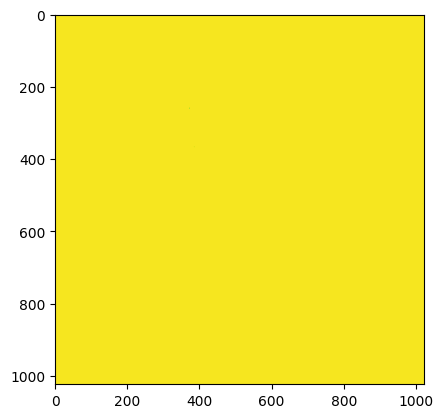

In [15]:
print(u_ten)
plt.imshow(u_ten[0])

Now using the predicted optical flow fields register all the images in the images stack to the reference image.

In [16]:
Z_reg = np.zeros([C,H,W]) #tensor to hold registered images

for ii in range(C):
  print(ii)
  # estimate the total flow from frame ii to the reference frame
  # now perform the registration - can use scikit's warp
  # store the results

  if ii < ref_idx:
    warp_u, warp_v = np.sum(u_ten[ii:ref_idx, :, :], axis=0), np.sum(u_ten[ii:ref_idx, :, :], axis=0)
  elif ii > ref_idx:
    warp_u, warp_v = np.sum(u_ten[ref_idx:ii, :, :], axis=0), np.sum(v_ten[ref_idx:ii, :, :], axis=0)
  else:
    warp_u = np.zeros([H,W])
    warp_v = np.zeros([H,W])

  row_coords, col_coords = np.meshgrid(np.arange(H), np.arange(W), indexing='ij')
  result = warp(copy.deepcopy(Z[ii]), np.array([row_coords - warp_u, col_coords - warp_v]), mode = "edge", cval = 0)
  Z_reg[ii,:,:] = result


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20


[[0.30645161 0.30107527 0.30107527 ... 0.29569892 0.30107527 0.30107527]
 [0.30107527 0.30185421 0.29412638 ... 0.29231425 0.29710978 0.30107527]
 [0.29569892 0.29108422 0.29130941 ... 0.28963768 0.29551318 0.30107527]
 ...
 [0.90860215 0.91791033 0.91700281 ... 0.90661003 0.90778537 0.90860215]
 [0.92473118 0.91983583 0.91003396 ... 0.90366862 0.90344887 0.89784946]
 [0.91397849 0.91397849 0.91397849 ... 0.90322581 0.91935484 0.86021505]]


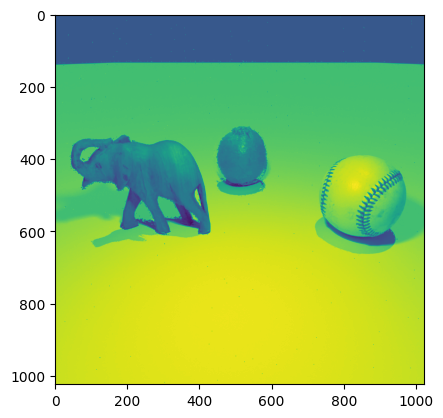

In [17]:
kk=15
print(Z_reg[kk])
plt.imshow(Z_reg[kk])

Text(0.5, 1.0, 'Scene Motion - Clean Reg Avg\nPSNR 28.282619273995707')

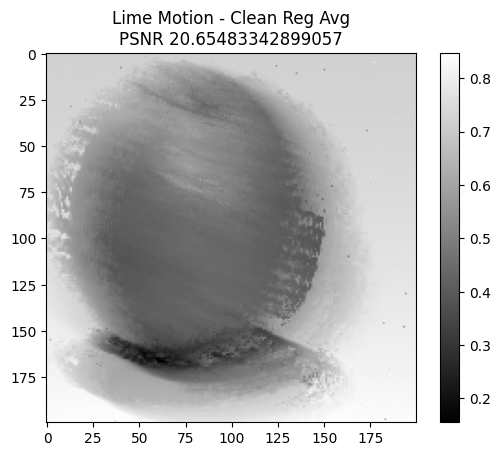

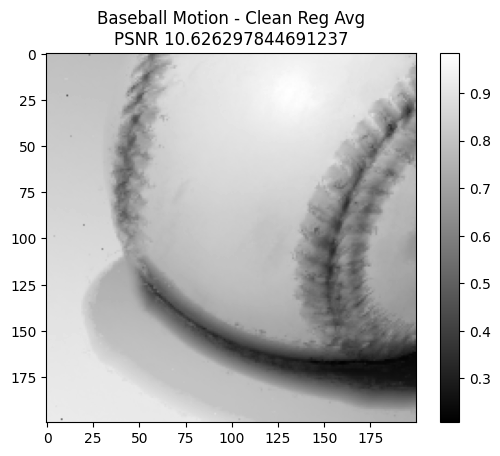

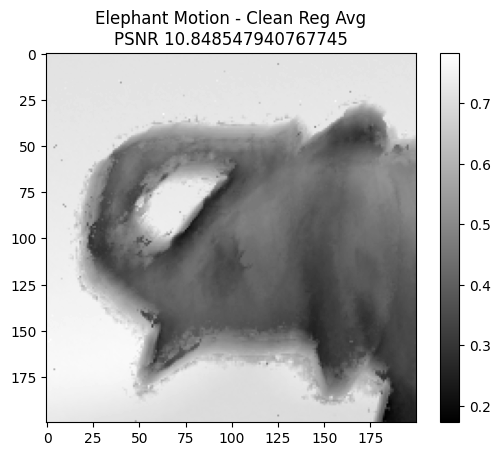

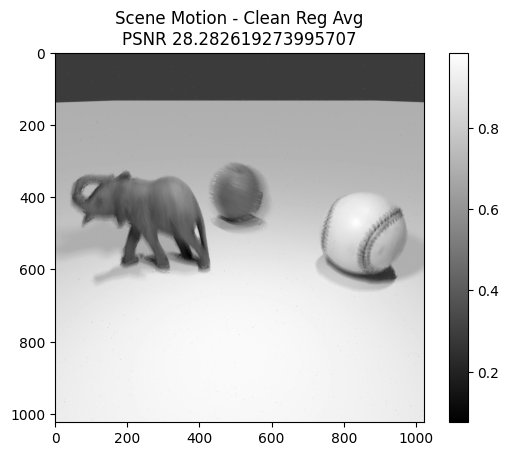

In [18]:
# Show an average over all frames in the registered clean image stack

Z_reg_crop1 = Z_reg[:,crop1[0]:crop1[1],crop1[2]:crop1[3]]
Z_reg_crop2 = Z_reg[:,crop2[0]:crop2[1],crop2[2]:crop2[3]]
Z_reg_crop3 = Z_reg[:,crop3[0]:crop3[1],crop3[2]:crop3[3]]

'''
TODO:
Compute and display averaged image for Z_reg_crop1, Z_reg_crop2,
Z_reg_crop3, and complete image Z_reg_averaged
'''

Z_reg_crop1_avg = np.mean(Z_reg_crop1, axis=0)
Z_reg_crop2_avg = np.mean(Z_reg_crop2, axis=0)
Z_reg_crop3_avg = np.mean(Z_reg_crop3, axis=0)
Z_reg_averaged = np.mean(Z_reg, axis=0)

plt.figure()
plt.imshow(Z_reg_crop1_avg, cmap='gray')
plt.colorbar()
plt.title('Lime Motion - Clean Reg Avg'+ '\nPSNR ' + str(psnr(normalize_2D(Z_reg_crop1_avg),
                                                              normalize_2D(Z[ref_idx])[crop1[0]:crop1[1],crop1[2]:crop1[3]])))

plt.figure()
plt.imshow(Z_reg_crop2_avg, cmap='gray')
plt.colorbar()
plt.title('Baseball Motion - Clean Reg Avg'+ '\nPSNR ' + str(psnr(normalize_2D(Z_reg_crop2_avg),
                                                              normalize_2D(Z[ref_idx])[crop1[0]:crop1[1],crop1[2]:crop1[3]])))

plt.figure()
plt.imshow(Z_reg_crop3_avg, cmap='gray')
plt.colorbar()
plt.title('Elephant Motion - Clean Reg Avg'+ '\nPSNR ' + str(psnr(normalize_2D(Z_reg_crop3_avg),
                                                              normalize_2D(Z[ref_idx])[crop1[0]:crop1[1],crop1[2]:crop1[3]])))

plt.figure()
plt.imshow(Z_reg_averaged, cmap='gray')
plt.colorbar()
plt.title('Scene Motion - Clean Reg Avg'+ '\nPSNR ' + str(psnr(normalize_2D(Z_reg_averaged),
                                                              normalize_2D(Z[ref_idx]))))

Text(0.5, 1.0, 'Scene Motion - Avg\nPSNR 29.96034121517369')

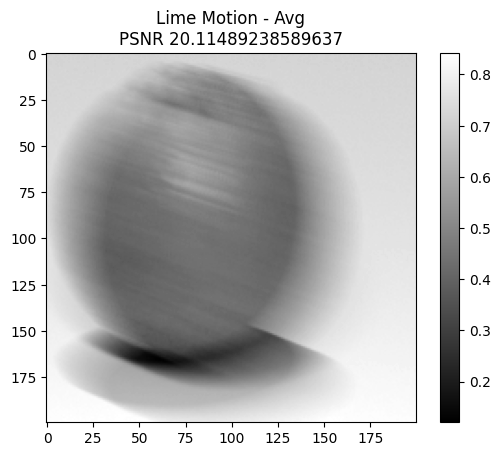

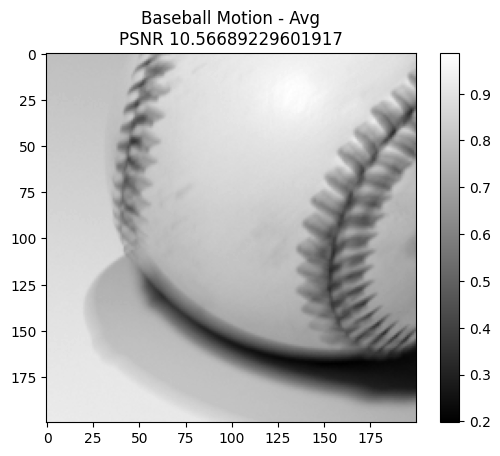

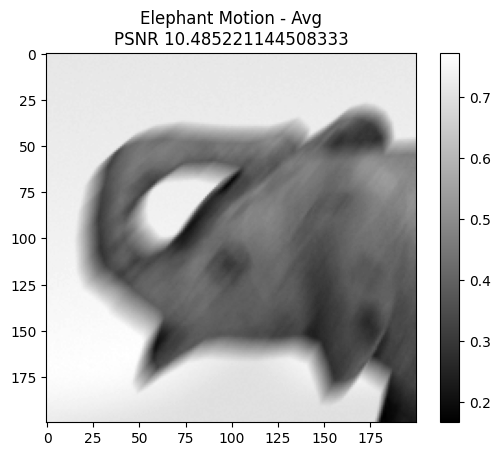

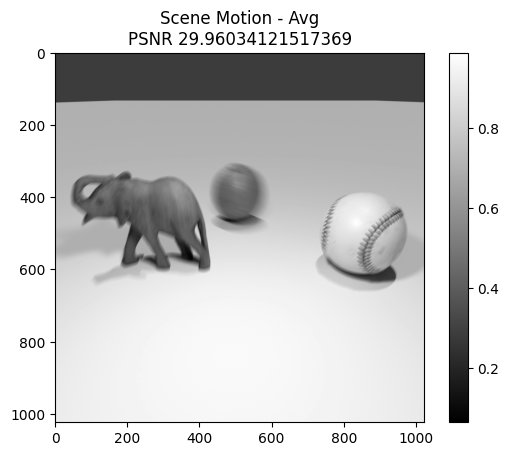

In [19]:
# Show an average over all frames in the unregistered clean image stack

Z_crop1 = Z[:,crop1[0]:crop1[1],crop1[2]:crop1[3]]
Z_crop2 = Z[:,crop2[0]:crop2[1],crop2[2]:crop2[3]]
Z_crop3 = Z[:,crop3[0]:crop3[1],crop3[2]:crop3[3]]

'''
TODO:
Compute and display averaged image for Z_reg_crop1, Z_reg_crop2,
Z_reg_crop3, and complete image Z_reg_averaged
'''

Z_crop1_avg = np.mean(Z_crop1, axis=0)
Z_crop2_avg = np.mean(Z_crop2, axis=0)
Z_crop3_avg = np.mean(Z_crop3, axis=0)
Z_averaged = np.mean(Z, axis=0)

plt.figure()
plt.imshow(Z_crop1_avg, cmap='gray')
plt.colorbar()
plt.title('Lime Motion - Avg'+ '\nPSNR ' + str(psnr(normalize_2D(Z_crop1_avg),
                                                              normalize_2D(Z[ref_idx])[crop1[0]:crop1[1],crop1[2]:crop1[3]])))

plt.figure()
plt.imshow(Z_crop2_avg, cmap='gray')
plt.colorbar()
plt.title('Baseball Motion - Avg'+ '\nPSNR ' + str(psnr(normalize_2D(Z_crop2_avg),
                                                              normalize_2D(Z[ref_idx])[crop1[0]:crop1[1],crop1[2]:crop1[3]])))

plt.figure()
plt.imshow(Z_crop3_avg, cmap='gray')
plt.colorbar()
plt.title('Elephant Motion - Avg'+ '\nPSNR ' + str(psnr(normalize_2D(Z_crop3_avg),
                                                              normalize_2D(Z[ref_idx])[crop1[0]:crop1[1],crop1[2]:crop1[3]])))

plt.figure()
plt.imshow(Z_averaged, cmap='gray')
plt.colorbar()
plt.title('Scene Motion - Avg'+ '\nPSNR ' + str(psnr(normalize_2D(Z_averaged),
                                                              normalize_2D(Z[ref_idx]))))

<ipython-input-5-672b91fb189f>:19: RuntimeWarning: divide by zero encountered in double_scalars
  return 20*np.log10(np.max(ref)/RMSE)


Text(0.5, 1.0, 'Scene Motion - Ref\nPSNR inf')

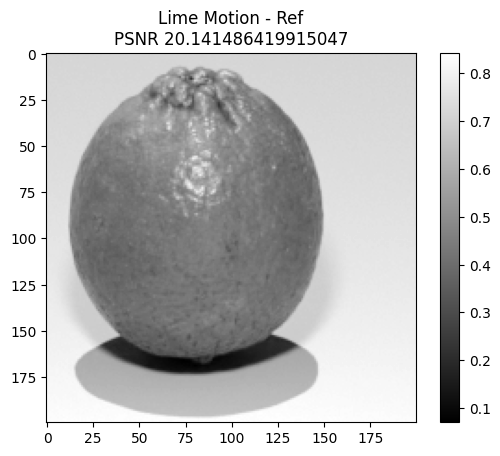

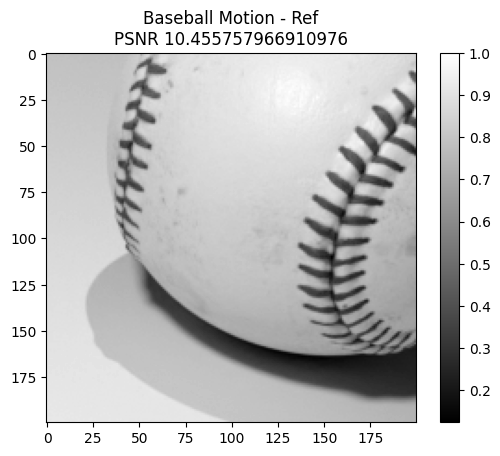

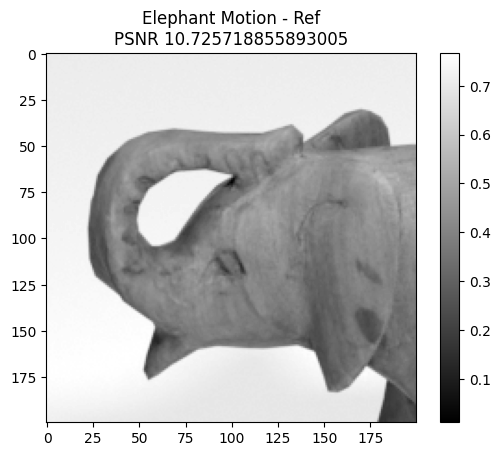

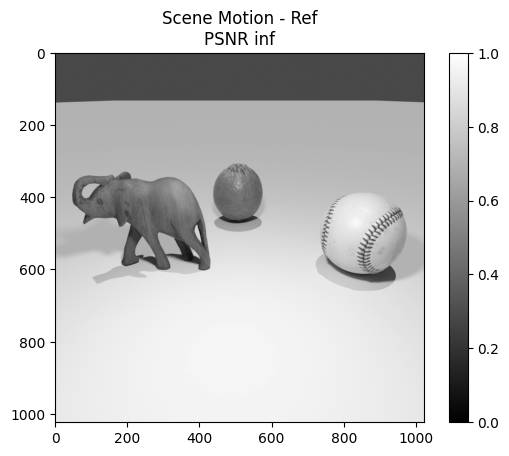

In [20]:
# Show cropped reference frame

Z_ref_crop1 = Z[ref_idx,crop1[0]:crop1[1],crop1[2]:crop1[3]]
Z_ref_crop2 = Z[ref_idx,crop2[0]:crop2[1],crop2[2]:crop2[3]]
Z_ref_crop3 = Z[ref_idx,crop3[0]:crop3[1],crop3[2]:crop3[3]]

'''
TODO:
Compute and display averaged image for Z_reg_crop1, Z_reg_crop2,
Z_reg_crop3, and complete image Z_reg_averaged
'''

plt.figure()
plt.imshow(Z_ref_crop1, cmap='gray')
plt.colorbar()
plt.title('Lime Motion - Ref'+ '\nPSNR ' + str(psnr(normalize_2D(Z_ref_crop1),
                                                              normalize_2D(Z[ref_idx])[crop1[0]:crop1[1],crop1[2]:crop1[3]])))

plt.figure()
plt.imshow(Z_ref_crop2, cmap='gray')
plt.colorbar()
plt.title('Baseball Motion - Ref'+ '\nPSNR ' + str(psnr(normalize_2D(Z_ref_crop2),
                                                              normalize_2D(Z[ref_idx])[crop1[0]:crop1[1],crop1[2]:crop1[3]])))

plt.figure()
plt.imshow(Z_ref_crop3, cmap='gray')
plt.colorbar()
plt.title('Elephant Motion - Ref'+ '\nPSNR ' + str(psnr(normalize_2D(Z_ref_crop3),
                                                              normalize_2D(Z[ref_idx])[crop1[0]:crop1[1],crop1[2]:crop1[3]])))

plt.figure()
plt.imshow(Z[ref_idx], cmap='gray')
plt.colorbar()
plt.title('Scene Motion - Ref'+ '\nPSNR ' + str(psnr(normalize_2D(Z[ref_idx]),
                                                              normalize_2D(Z[ref_idx]))))

# Noisy Image Stack
In this section the image stack containing motion is now corrupted with noise. The images need to now be registed and then denoised which becomes a much more challenging problem.

In [21]:
Z_noise = np.load("noisy_img_stack.npy")
print(Z_noise.shape)

(21, 1024, 1024)


Text(0.5, 1.0, 'Scene Motion - Noise Reg Avg\nPSNR 28.490778018782308')

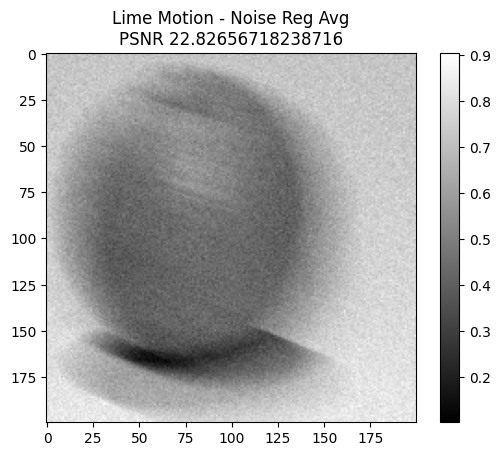

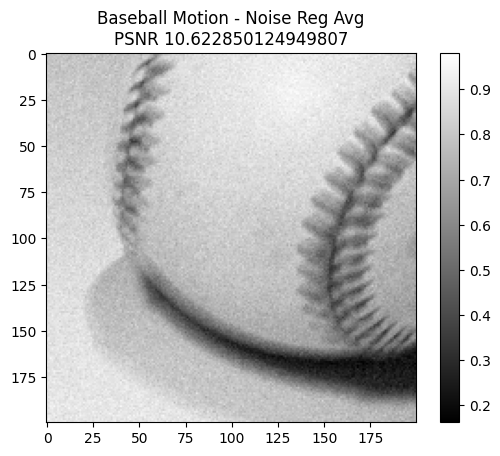

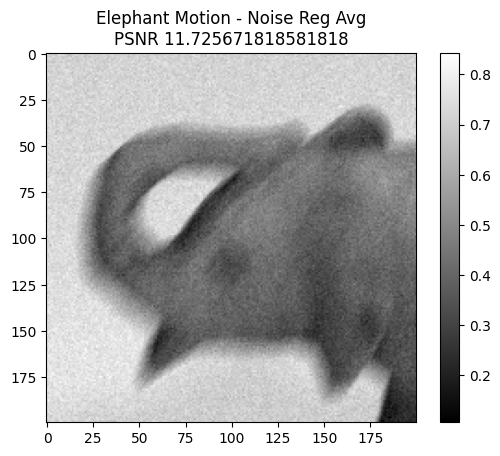

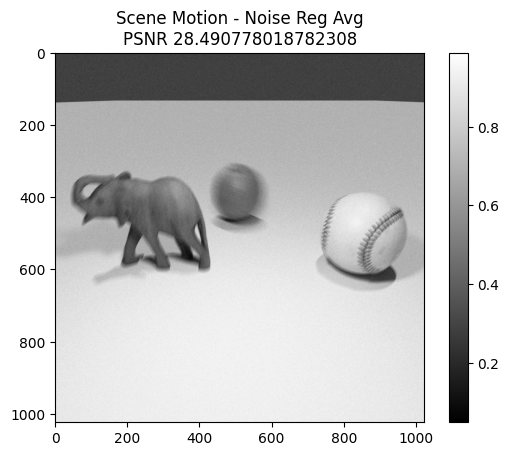

In [22]:
# Show an average over all frames in the registered noisy image stack

Z_noise_crop1 = Z_noise[:,crop1[0]:crop1[1],crop1[2]:crop1[3]]
Z_noise_crop2 = Z_noise[:,crop2[0]:crop2[1],crop2[2]:crop2[3]]
Z_noise_crop3 = Z_noise[:,crop3[0]:crop3[1],crop3[2]:crop3[3]]

'''
TODO:
Compute and display averaged image for Z_reg_crop1, Z_reg_crop2,
Z_reg_crop3, and complete image Z_reg_averaged
'''

Z_noise_crop1_avg = np.mean(Z_noise_crop1, axis=0)
Z_noise_crop2_avg = np.mean(Z_noise_crop2, axis=0)
Z_noise_crop3_avg = np.mean(Z_noise_crop3, axis=0)
Z_noise_averaged = np.mean(Z_noise, axis=0)
'''
TODO:
Compute and display averaged image for Z_noise_crop1, Z_noise_crop2,
Z_noise_crop3, and complete image Z_noise_averaged
'''

plt.figure()
plt.imshow(Z_noise_crop1_avg, cmap='gray')
plt.colorbar()
plt.title('Lime Motion - Noise Reg Avg'+ '\nPSNR ' + str(psnr(normalize_2D(Z_noise_crop1_avg),
                                                              normalize_2D(Z[ref_idx])[crop1[0]:crop1[1],crop1[2]:crop1[3]])))

plt.figure()
plt.imshow(Z_noise_crop2_avg, cmap='gray')
plt.colorbar()
plt.title('Baseball Motion - Noise Reg Avg'+ '\nPSNR ' + str(psnr(normalize_2D(Z_noise_crop2_avg),
                                                              normalize_2D(Z[ref_idx])[crop1[0]:crop1[1],crop1[2]:crop1[3]])))

plt.figure()
plt.imshow(Z_noise_crop3_avg, cmap='gray')
plt.colorbar()
plt.title('Elephant Motion - Noise Reg Avg'+ '\nPSNR ' + str(psnr(normalize_2D(Z_noise_crop3_avg),
                                                              normalize_2D(Z[ref_idx])[crop1[0]:crop1[1],crop1[2]:crop1[3]])))

plt.figure()
plt.imshow(Z_noise_averaged, cmap='gray')
plt.colorbar()
plt.title('Scene Motion - Noise Reg Avg'+ '\nPSNR ' + str(psnr(normalize_2D(Z_noise_averaged),
                                                              normalize_2D(Z[ref_idx]))))

## No Optical Flow Linear Denoising
Here apply linear multi-image denoising technique developed in part 1 of HW 1.This will be used as a base case in your analysis.

In [23]:
"""DENOISING METHODS"""
def linear_filt_avg(Y, block_sz):
  '''
  TODO:
  This program implements linear filtering by averaging blocks within
  a noisy image stack.
  Y = noisy image stack of size [C,H,W]
  block_sz = block size that will be averaged over [k,m,n]
  For each image pixel, assign the average value of the block around it
  '''
  # implement fast convolution with fft in numpy
  # set up a boxcar filter as conv with 1/kmn weights
  box_filter = np.ones(shape=block_sz) * 1/np.prod(block_sz)
  img_avg = fftconvolve(Y, box_filter, mode='same')
  # since using "same" results in the same dimensions,
  # we take the center image.

  return img_avg[img_avg.shape[0]//2]

def nonlinear_filt_median(Y, block_sz):
  '''
  TODO:
  This program implements nonlinear filtering by taking median of blocks within
  a noisy image stack.
  Y = noisy image stack of size [C,H,W]
  block_sz = block size that will have median taken [k,m,n]
  For each image pixel, assign the median value of the block around it
  '''
  Y_ext = np.lib.pad(Y,((0, 0),(block_sz[1],block_sz[2]),(block_sz[1],block_sz[2])),'reflect')
  img_median = np.zeros(Y.shape[1:])
  for i in range(block_sz[1], block_sz[1] + Y.shape[1]):
    for j in range(block_sz[2], block_sz[2] + Y.shape[2]):
      img_median[i - block_sz[1], j - block_sz[2]] = np.median(Y_ext[:block_sz[0], i - block_sz[1]:i + block_sz[1],
                                                                     j - block_sz[2]:j + block_sz[2]])

  return img_median

In [24]:
"""3D WAVELET DENOISING"""
def wavelet3D(x):
  return pywt.dwtn(x, 'db4')

def iwavelet3D(x):
  return pywt.idwtn(x, 'db4')

def wavelet3D_2(x):
  return pywt.dwtn(x, 'db2')

def iwavelet3D_2(x):
  return pywt.idwtn(x, 'db2')

def wavelet3D_3(x):
  return pywt.dwtn(x, 'db1')

def iwavelet3D_3(x):
  return pywt.idwtn(x, 'db1')

def unravel_wavecoeff_3d(data_dict):
    num_list = []
    for key, array in data_dict.items():
        # Flatten the nested array and extend the num_list
        num_list.extend(array.flatten())
    return num_list

def replace_wiener_3d(data_dict, sigma_estimate):
    # Create a new dictionary to store arrays with zeros
    zeroed_dict = {}

    # Iterate through the keys in the input dictionary
    for key, array in data_dict.items():
        # Create a new array of the same shape as the original with all zeros
        new_array = np.array([i**2/(i**2 + sigma_estimate**2) for i in array])

        # Add the zeroed array to the new dictionary
        zeroed_dict[key] = new_array

    return zeroed_dict

def chop_wiener_3d(data_dict, threshold):
    # Create a new dictionary to store arrays with zeros
    zeroed_dict = {}

    # Iterate through the keys in the input dictionary
    for key, array in data_dict.items():
        # Create a new array of the same shape as the original with all zeros
        zeroed_array = np.where(array > 0, array, 0)

        # Add the zeroed array to the new dictionary
        zeroed_dict[key] = zeroed_array

    return zeroed_dict

def ot_denoising3D(img_stack, transform=wavelet3D, inv_transform=iwavelet3D, additional_parameters_if_required=None, percent_lo=0.25, percent_hi=1):
  '''
  TODO:
  Implement the following -
  1. Apply the OT3D
  2. Use a transform of your choice
  3. Apply Inverse OT to go back to image domain and return
  Uncomment the last line to return
  '''
  # same algo but 3d
  # img = normalize_2D(img)
  frac = 1000 # 10000*5 for dct, 1000 for db4
  # percent_lo = 0.25
  # 0 gives clearer img, lower snr. 0.00025 gives blurrier img but better snr with dct
  # 0.0025 for db4 on default settings gives 29.49 psnr, ringing artifacts around the objects, hi 0.25
  # lo 0.0025 hi 0.01 for db8 gives 23 psnr
  # percent_hi = 1
  # could use an integral to determine a set % of power for these thresholds using parseval's thm
  # just use DCT for now
  # apply OT
  img_ot = transform(img_stack)
  # print(img_ot)
  img_ot_copy = copy.deepcopy(img_ot)
  if transform == wavelet3D:
    img_ot = unravel_wavecoeff_3d(img_ot)
  # print(img_ot)
  # print()
  #print(img_ot.shape)

  # sigma should be around 0.2-0.4

  # then sort eigenvalues
  eig_sorted = np.flip(np.sort(np.ndarray.flatten(np.abs(img_ot))))
  print(eig_sorted.shape, 1080*1920)
  # plt.scatter(range(eig_sorted.shape[0]//frac), eig_sorted[:eig_sorted.shape[0]//frac])

  # we can use the 3rd and 4th standard deviations or some statistical/energy threshold to determine these thresholds
  # can chop
  thresh_lo = percent_lo*eig_sorted[0]
  thresh_hi = percent_hi*eig_sorted[0]
  chopped = np.where(eig_sorted > thresh_lo, eig_sorted, 0)
  chopped2 = np.where(chopped > thresh_hi, chopped, 0)
  # plt.scatter(range(eig_sorted.shape[0]//frac), chopped[:eig_sorted.shape[0]//frac])
  # plt.plot(range(eig_sorted.shape[0]//frac), chopped2[:eig_sorted.shape[0]//frac])
  # print(chopped, thresh_lo)



  # === double threshold richb algo ===
  # can use 2 thresholds to approximate non-zero low coefficients, average them to get variance estimate for chop
  chopdiff = chopped - chopped2
  mean_array = chopdiff[chopdiff != 0]
  sigma_estimate = np.mean(mean_array)
  print("initial sigma estimate:", sigma_estimate)


  '''SECOND AND THIRD TRANSFORMS --- RICHB'''
  # # === SECOND TRANSFORM STARTS HERE===
  # # print(img_ot_copy)
  # chopped_inorder = chop_wiener_3d(img_ot_copy, thresh_hi)
  # # print(img_ot_copy)
  # # transform back and then transform into the 2nd transform
  # temp_img = iwavelet3D(chopped_inorder)

  # # transform with 2nd transform
  # img_ot_2 = wavelet3D_2(temp_img)
  # img_ot_2_copy = copy.deepcopy(img_ot_2)
  # if transform == wavelet3D:
  #   img_ot_2 = unravel_wavecoeff_3d(img_ot_2)
  # # perform double thresholding once again
  # # sort eigenvalues
  # eig_sorted_2 = np.flip(np.sort(np.ndarray.flatten(np.abs(img_ot_2))))
  # print(eig_sorted_2.shape, 1080*1920)
  # plt.scatter(range(eig_sorted_2.shape[0]//frac), eig_sorted_2[:eig_sorted_2.shape[0]//frac])

  # # we can use the 3rd and 4th standard deviations to determine these thresholds
  # # can chop
  # thresh_lo_2 = percent_lo*eig_sorted_2[0]
  # thresh_hi_2 = percent_hi*eig_sorted_2[0]
  # chopped_2 = np.where(eig_sorted_2 > thresh_lo_2, eig_sorted_2, 0)
  # chopped2_2 = np.where(chopped_2 > thresh_hi_2, chopped_2, 0)
  # plt.scatter(range(eig_sorted_2.shape[0]//frac), chopped_2[:eig_sorted_2.shape[0]//frac])
  # plt.plot(range(eig_sorted_2.shape[0]//frac), chopped2_2[:eig_sorted_2.shape[0]//frac])
  # # print(chopped, thresh_lo)

  # # === double threshold richb algo ===
  # # can use 2 thresholds to approximate non-zero low coefficients, average them to get variance estimate for chop
  # chopdiff_2 = chopped_2 - chopped2_2
  # mean_array_2 = chopdiff_2[chopdiff_2 != 0]
  # sigma_estimate_2 = (np.sum(mean_array) + np.sum(mean_array_2))/(len(mean_array) + len(mean_array_2))
  # print("updated sigma estimate:", sigma_estimate_2)
  # # === END SECOND TRANSFORM ===


  # # === THIRD TRANSFORM STARTS HERE===
  # # print(img_ot_copy)
  # chopped_inorder = chop_wiener_3d(img_ot_2_copy, thresh_hi_2)
  # # print(img_ot_copy)
  # # transform back and then transform into the 2nd transform
  # temp_img_2 = iwavelet3D_2(chopped_inorder)

  # # transform with 3rd transform
  # img_ot_3 = wavelet3D_3(temp_img_2)
  # #img_ot_2_copy = img_ot_2.copy()
  # if transform == wavelet3D:
  #   img_ot_3 = unravel_wavecoeff_3d(img_ot_3)
  # # perform double thresholding once again
  # # sort eigenvalues
  # eig_sorted_3 = np.flip(np.sort(np.ndarray.flatten(np.abs(img_ot_3))))
  # print(eig_sorted_3.shape, 1080*1920)
  # plt.scatter(range(eig_sorted_3.shape[0]//frac), eig_sorted_3[:eig_sorted_3.shape[0]//frac])

  # # we can use the 3rd and 4th standard deviations to determine these thresholds
  # # can chop
  # thresh_lo_3 = percent_lo*eig_sorted_3[0]
  # thresh_hi_3 = percent_hi*eig_sorted_3[0]
  # chopped_3 = np.where(eig_sorted_3 > thresh_lo_3, eig_sorted_3, 0)
  # chopped2_3 = np.where(chopped_3 > thresh_hi_3, chopped_3, 0)
  # plt.scatter(range(eig_sorted_3.shape[0]//frac), chopped_3[:eig_sorted_3.shape[0]//frac])
  # plt.plot(range(eig_sorted_3.shape[0]//frac), chopped2_3[:eig_sorted_3.shape[0]//frac])
  # # print(chopped, thresh_lo)

  # # === double threshold richb algo ===
  # # can use 2 thresholds to approximate non-zero low coefficients, average them to get variance estimate for chop
  # chopdiff_3 = chopped_3 - chopped2_3
  # mean_array_3 = chopdiff_3[chopdiff_3 != 0]
  # sigma_estimate_3 = (np.sum(mean_array) + np.sum(mean_array_2) + np.sum(mean_array_3))/(len(mean_array) + len(mean_array_2) + len(mean_array_3))
  # print("updated sigma estimate:", sigma_estimate_3)
  # # === END THIRD TRANSFORM ===




  # apply wiener filter on eigens
  # test -- crude method by just removing some
  new_coeffs = img_ot_copy.copy()
  new_coeffs = replace_wiener_3d(new_coeffs, sigma_estimate)
  # === end of algo ===



  # === this gives 22 psnr but rly bad image -- this is hard thresholding ===
  # new_coeffs = np.where(np.abs(img_ot) > thresh_lo*8, img_ot, 0)
  # print(new_coeffs)
  # === end of hard thresholding ===

  # put it back
  # inv dct requires at least 2 nonzero coefficients, since there's max - min in denominator
  img_ot_denoised = inv_transform(new_coeffs)

  # once we put it back, we can rotate our transform some degrees between space domain and transform domain
  # set the same hard 2nd threshold, then add the nonzero points to the sigma estimate average

  # then use new sigma estimate for 2nd wiener filter -- can repeat n times

  # plt.show()

  # # we're not going to average because
  # # a: we seem to get a DC component problem?
  # # b: we dont want to blur in case the images aren't aligned -- the point is to not have to blur
  # # so we pick the image with the highest psnr
  # snrs = []
  # for single_img in img_ot_denoised:
  #   snrs.append(psnr(img,normalize_2D(single_img)))
  # snrs = np.array(snrs)

  return img_ot_denoised#np.mean(img_ot_denoised, axis=0)

In [25]:
X_avg = linear_filt_avg(Z, [6, 2, 2]) # From Part1

## No Optical Flow Nonlinear Denoising
Here apply nonlinear multi-image denoising technique develoepd in part 1 of HW 1. This will be used as a base case in your analysis.

In [26]:
X_med = nonlinear_filt_median(Z, [6, 2, 2]) # From Part 1

## No Optical Flow Compressed Sensing Denoising
Here apply CS multi-image denoising tehcnique developed in part 1 of HW 1. This will be used as a base case in your analysis.

In [27]:
X_cs = np.mean(ot_denoising3D(Z), axis=0)# From Part 1

(29705200,) 2073600
initial sigma estimate: 2.0657282034896185


## Estimate Optical Flow for Noisy Image Stack
Now estimate the optical flow $(u,v)$ between all the images in the noisy image stack.

In [28]:
ref_idx = 10
window_size = 3

[C,H,W] = Z_noise.shape
u_ten_noise = np.zeros([C,H,W])
v_ten_noise = np.zeros([C,H,W])

for ii in range(C):
  print(ii)
  if ii < ref_idx:
    u,v = kl_optical_flow(Z_noise[ii+1,:,:],Z_noise[ii,:,:],window_size)
  elif ii > ref_idx:
    u,v = kl_optical_flow(Z_noise[ii-1,:,:],Z_noise[ii,:,:],window_size)
  else:
    u = np.zeros([H,W])
    v = np.zeros([H,W])

  # store the results
  u_ten_noise[ii,:,:] = u
  v_ten_noise[ii,:,:] = v

0


<ipython-input-13-7db0490c9cb0>:67: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  optflow = np.linalg.lstsq(A,b)


1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20


## Warp Images in Noisy Image Stack
Now using the estimated flow field warp all images in the noisy image stack to the reference frame to correct for motion artifacts

In [29]:
'''
TODO
'''
Z_reg_noise = np.zeros([C,H,W]) #tensor to hold registered images
for ii in range(C):
  print(ii)
  # estimate the total flow from frame ii to the reference frame
  # now perform the registration - can use scikit's warp
  # store the results

  if ii < ref_idx:
    warp_u, warp_v = np.sum(u_ten_noise[ii:ref_idx], axis=0), np.sum(u_ten_noise[ii:ref_idx], axis=0)
  elif ii > ref_idx:
    warp_u, warp_v = np.sum(u_ten_noise[ref_idx:ii], axis=0), np.sum(v_ten_noise[ref_idx:ii], axis=0)
  else:
    warp_u = np.zeros([H,W])
    warp_v = np.zeros([H,W])

  row_coords, col_coords = np.meshgrid(np.arange(H), np.arange(W), indexing='ij')
  result = warp(copy.deepcopy(Z_noise[ii]), np.array([row_coords - warp_u, col_coords - warp_v]))
  Z_reg_noise[ii,:,:] = result



0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20


## Optical Flow + Linear Multi-image Denoising
Here use the linear denoising technqiue developed in Part 1 of HW 1.

In [30]:
X_avg_reg = linear_filt_avg(Z_reg_noise, [6, 2, 2])

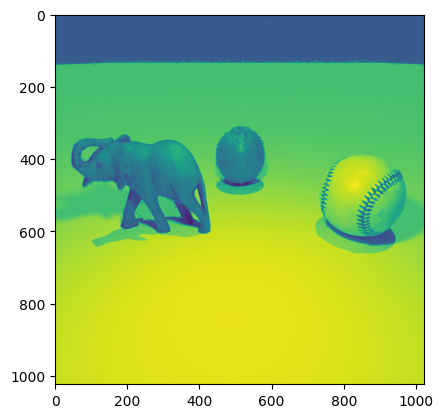

In [31]:
plt.imshow(Z_reg[13])

## Optical Flow + Nonlinear Multi-image Denoising
Here use the nonlinear denoising technque developed in Part 1 of HW 1.

In [32]:
X_med_reg = nonlinear_filt_median(Z_reg_noise, [6, 2, 2])

## Optical Flow + Compressed Sensing Multi-image Denoising
Here use the CS denoising technique developed in Part 1 HW 1.

In [33]:
X_cs_reg = linear_filt_avg(ot_denoising3D(Z_reg_noise), [6, 2, 2])

(29705200,) 2073600
initial sigma estimate: 2.1763531636724887


## Plot Noisy Image Optical Flow + Denoising Results
Here compare reconstruction results for just the zoomed in crop regions (lime, elephant, and baseball)

In [34]:
X_gt = cv2.imread('gt.png') # read from the given data
X_gt = np.mean(X_gt, axis=2)

In [35]:
print(X_cs.shape)

(1024, 1024)


<ipython-input-5-672b91fb189f>:19: RuntimeWarning: divide by zero encountered in double_scalars
  return 20*np.log10(np.max(ref)/RMSE)


Text(0.5, 1.0, 'Ground Truth\nPSNR inf')

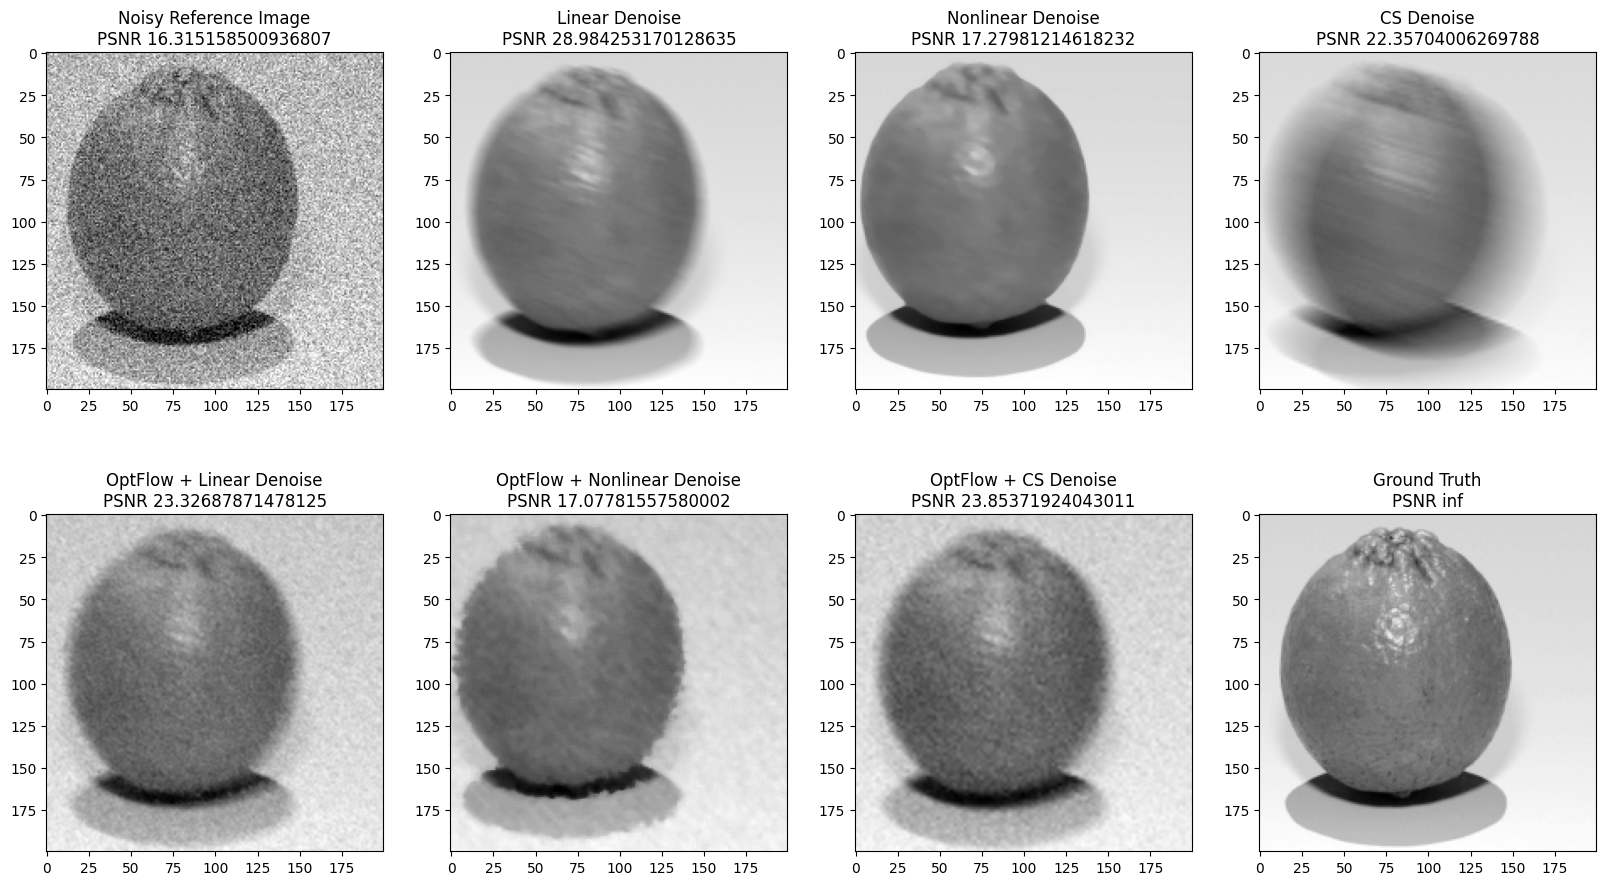

In [36]:
crop = crop1    # lime crop boundaries
cmap_color = 'gray'#'viridis'

fig, axs = plt.subplots(2, 4,figsize=(20,11))
# fig.suptitle('Denoising Methods')
axs[0,0].imshow(Z_noise[ref_idx,crop[0]:crop[1],crop[2]:crop[3]], cmap=cmap_color)
axs[0,0].set_title('Noisy Reference Image' + '\nPSNR ' + str(psnr(normalize_2D(X_gt[crop[0]:crop[1],crop[2]:crop[3]]),
                                                              normalize_2D(Z_noise[ref_idx,crop[0]:crop[1],crop[2]:crop[3]]))))
axs[0,1].imshow(X_avg[crop[0]:crop[1],crop[2]:crop[3]], cmap=cmap_color)
axs[0,1].set_title('Linear Denoise'+ '\nPSNR ' + str(psnr(normalize_2D(X_gt[crop[0]:crop[1],crop[2]:crop[3]]),
                                                              normalize_2D(X_avg[crop[0]:crop[1],crop[2]:crop[3]]))))
axs[0,2].imshow(X_med[crop[0]:crop[1],crop[2]:crop[3]], cmap=cmap_color)
axs[0,2].set_title('Nonlinear Denoise'+ '\nPSNR ' + str(psnr(normalize_2D(X_gt[crop[0]:crop[1],crop[2]:crop[3]]),
                                                              normalize_2D(X_med[crop[0]:crop[1],crop[2]:crop[3]]))))
axs[0,3].imshow(X_cs[crop[0]:crop[1],crop[2]:crop[3]], cmap=cmap_color)
axs[0,3].set_title('CS Denoise'+ '\nPSNR ' + str(psnr(normalize_2D(X_gt[crop[0]:crop[1],crop[2]:crop[3]]),
                                                              normalize_2D(X_cs[crop[0]:crop[1],crop[2]:crop[3]]))))

axs[1,0].imshow(X_avg_reg[crop[0]:crop[1],crop[2]:crop[3]], cmap=cmap_color)
axs[1,0].set_title('OptFlow + Linear Denoise'+ '\nPSNR ' + str(psnr(normalize_2D(X_gt[crop[0]:crop[1],crop[2]:crop[3]]),
                                                              normalize_2D(X_avg_reg[crop[0]:crop[1],crop[2]:crop[3]]))))
axs[1,1].imshow(X_med_reg[crop[0]:crop[1],crop[2]:crop[3]], cmap=cmap_color)
axs[1,1].set_title('OptFlow + Nonlinear Denoise'+ '\nPSNR ' + str(psnr(normalize_2D(X_gt[crop[0]:crop[1],crop[2]:crop[3]]),
                                                              normalize_2D(X_med_reg[crop[0]:crop[1],crop[2]:crop[3]]))))
axs[1,2].imshow(X_cs_reg[crop[0]:crop[1],crop[2]:crop[3]], cmap=cmap_color)
axs[1,2].set_title('OptFlow + CS Denoise'+ '\nPSNR ' + str(psnr(normalize_2D(X_gt[crop[0]:crop[1],crop[2]:crop[3]]),
                                                              normalize_2D(X_cs_reg[crop[0]:crop[1],crop[2]:crop[3]]))))
axs[1,3].imshow(X_gt[crop[0]:crop[1],crop[2]:crop[3]], cmap=cmap_color)
axs[1,3].set_title('Ground Truth'+ '\nPSNR ' + str(psnr(normalize_2D(X_gt[crop[0]:crop[1],crop[2]:crop[3]]),
                                                              normalize_2D(X_gt[crop[0]:crop[1],crop[2]:crop[3]]))))

<ipython-input-5-672b91fb189f>:19: RuntimeWarning: divide by zero encountered in double_scalars
  return 20*np.log10(np.max(ref)/RMSE)


Text(0.5, 1.0, 'Ground Truth\nPSNR inf')

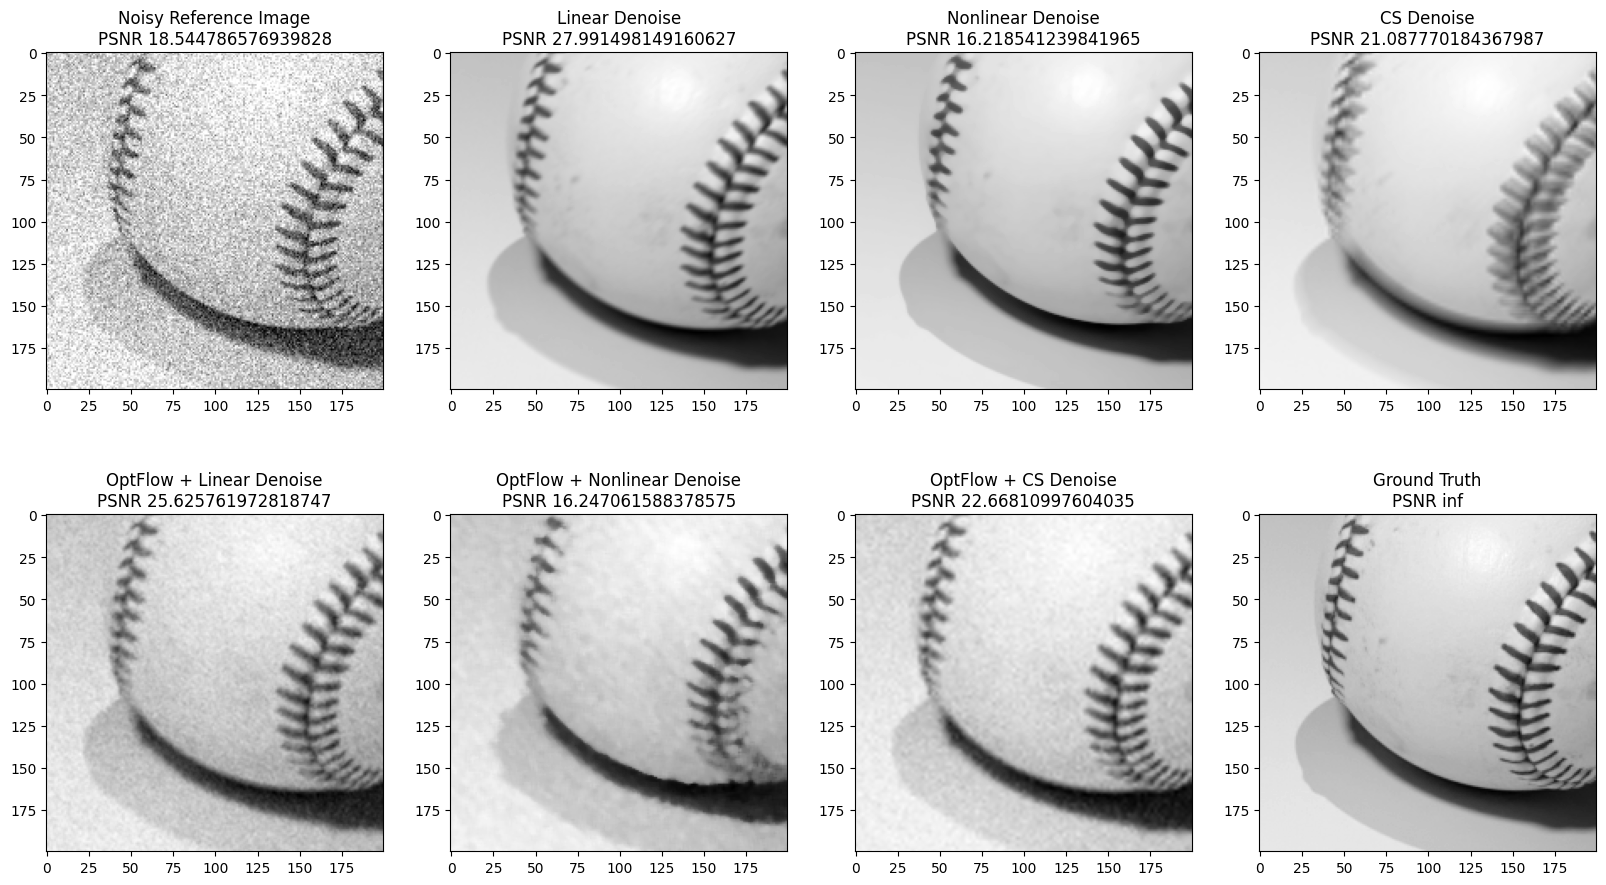

In [37]:
crop = crop2    # baseball crop boundaries
cmap_color = 'gray'#'viridis'

fig, axs = plt.subplots(2, 4,figsize=(20,11))
# fig.suptitle('Denoising Methods')
axs[0,0].imshow(Z_noise[ref_idx,crop[0]:crop[1],crop[2]:crop[3]], cmap=cmap_color)
axs[0,0].set_title('Noisy Reference Image' + '\nPSNR ' + str(psnr(normalize_2D(X_gt[crop[0]:crop[1],crop[2]:crop[3]]),
                                                              normalize_2D(Z_noise[ref_idx,crop[0]:crop[1],crop[2]:crop[3]]))))
axs[0,1].imshow(X_avg[crop[0]:crop[1],crop[2]:crop[3]], cmap=cmap_color)
axs[0,1].set_title('Linear Denoise'+ '\nPSNR ' + str(psnr(normalize_2D(X_gt[crop[0]:crop[1],crop[2]:crop[3]]),
                                                              normalize_2D(X_avg[crop[0]:crop[1],crop[2]:crop[3]]))))
axs[0,2].imshow(X_med[crop[0]:crop[1],crop[2]:crop[3]], cmap=cmap_color)
axs[0,2].set_title('Nonlinear Denoise'+ '\nPSNR ' + str(psnr(normalize_2D(X_gt[crop[0]:crop[1],crop[2]:crop[3]]),
                                                              normalize_2D(X_med[crop[0]:crop[1],crop[2]:crop[3]]))))
axs[0,3].imshow(X_cs[crop[0]:crop[1],crop[2]:crop[3]], cmap=cmap_color)
axs[0,3].set_title('CS Denoise'+ '\nPSNR ' + str(psnr(normalize_2D(X_gt[crop[0]:crop[1],crop[2]:crop[3]]),
                                                              normalize_2D(X_cs[crop[0]:crop[1],crop[2]:crop[3]]))))

axs[1,0].imshow(X_avg_reg[crop[0]:crop[1],crop[2]:crop[3]], cmap=cmap_color)
axs[1,0].set_title('OptFlow + Linear Denoise'+ '\nPSNR ' + str(psnr(normalize_2D(X_gt[crop[0]:crop[1],crop[2]:crop[3]]),
                                                              normalize_2D(X_avg_reg[crop[0]:crop[1],crop[2]:crop[3]]))))
axs[1,1].imshow(X_med_reg[crop[0]:crop[1],crop[2]:crop[3]], cmap=cmap_color)
axs[1,1].set_title('OptFlow + Nonlinear Denoise'+ '\nPSNR ' + str(psnr(normalize_2D(X_gt[crop[0]:crop[1],crop[2]:crop[3]]),
                                                              normalize_2D(X_med_reg[crop[0]:crop[1],crop[2]:crop[3]]))))
axs[1,2].imshow(X_cs_reg[crop[0]:crop[1],crop[2]:crop[3]], cmap=cmap_color)
axs[1,2].set_title('OptFlow + CS Denoise'+ '\nPSNR ' + str(psnr(normalize_2D(X_gt[crop[0]:crop[1],crop[2]:crop[3]]),
                                                              normalize_2D(X_cs_reg[crop[0]:crop[1],crop[2]:crop[3]]))))
axs[1,3].imshow(X_gt[crop[0]:crop[1],crop[2]:crop[3]], cmap=cmap_color)
axs[1,3].set_title('Ground Truth'+ '\nPSNR ' + str(psnr(normalize_2D(X_gt[crop[0]:crop[1],crop[2]:crop[3]]),
                                                              normalize_2D(X_gt[crop[0]:crop[1],crop[2]:crop[3]]))))

<ipython-input-5-672b91fb189f>:19: RuntimeWarning: divide by zero encountered in double_scalars
  return 20*np.log10(np.max(ref)/RMSE)


Text(0.5, 1.0, 'Ground Truth\nPSNR inf')

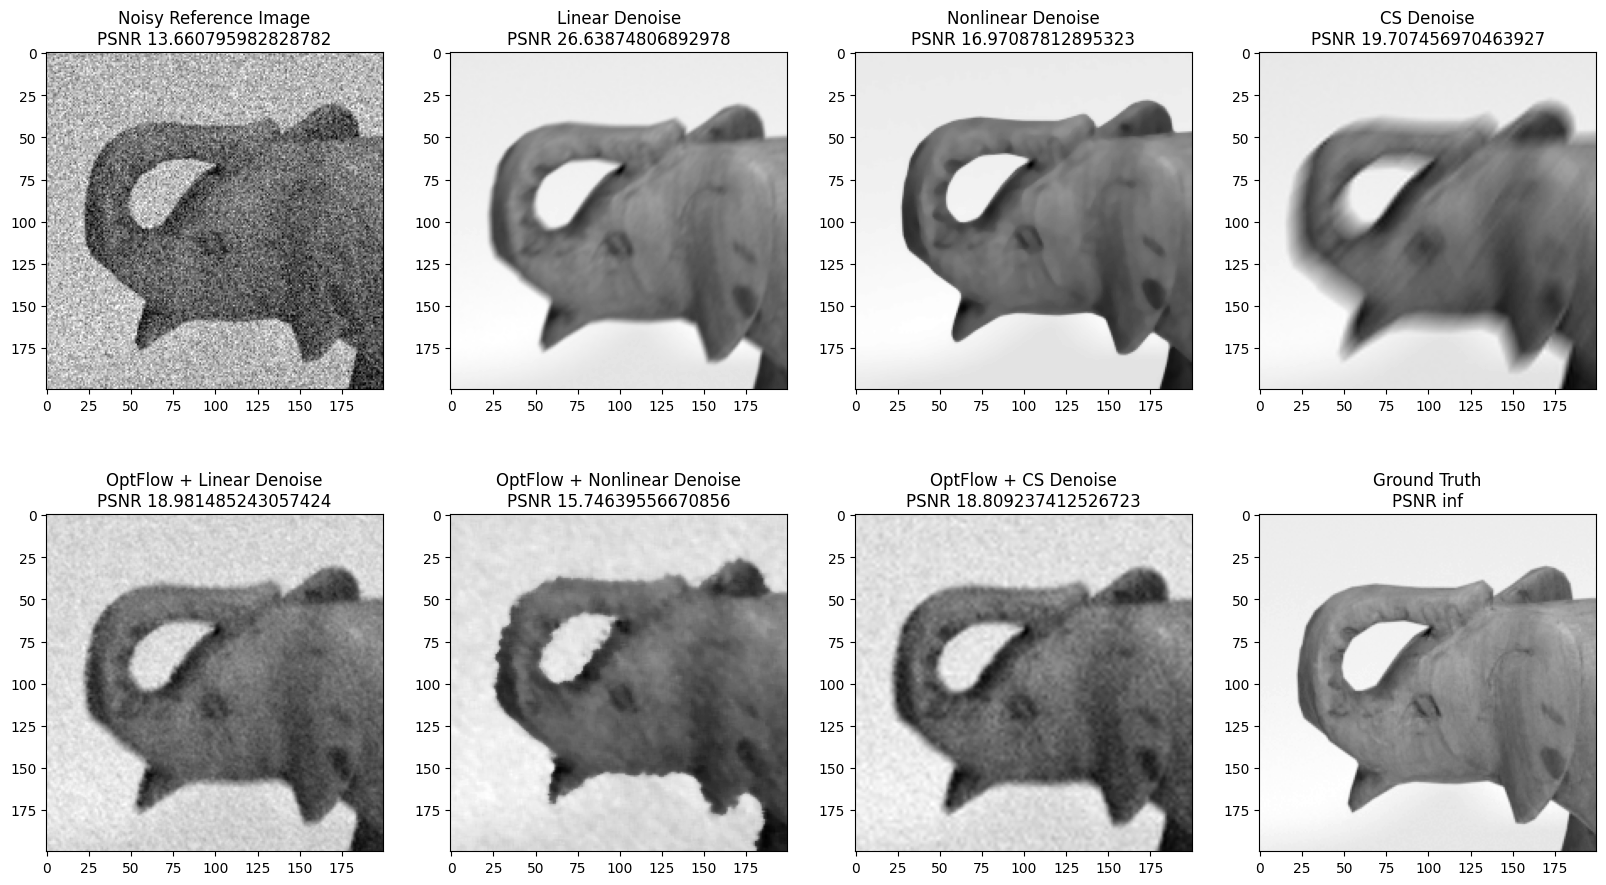

In [38]:
crop = crop3    # elephant crop boundaries
cmap_color = 'gray'#'viridis'

fig, axs = plt.subplots(2, 4,figsize=(20,11))
# fig.suptitle('Denoising Methods')
axs[0,0].imshow(Z_noise[ref_idx,crop[0]:crop[1],crop[2]:crop[3]], cmap=cmap_color)
axs[0,0].set_title('Noisy Reference Image' + '\nPSNR ' + str(psnr(normalize_2D(X_gt[crop[0]:crop[1],crop[2]:crop[3]]),
                                                              normalize_2D(Z_noise[ref_idx,crop[0]:crop[1],crop[2]:crop[3]]))))
axs[0,1].imshow(X_avg[crop[0]:crop[1],crop[2]:crop[3]], cmap=cmap_color)
axs[0,1].set_title('Linear Denoise'+ '\nPSNR ' + str(psnr(normalize_2D(X_gt[crop[0]:crop[1],crop[2]:crop[3]]),
                                                              normalize_2D(X_avg[crop[0]:crop[1],crop[2]:crop[3]]))))
axs[0,2].imshow(X_med[crop[0]:crop[1],crop[2]:crop[3]], cmap=cmap_color)
axs[0,2].set_title('Nonlinear Denoise'+ '\nPSNR ' + str(psnr(normalize_2D(X_gt[crop[0]:crop[1],crop[2]:crop[3]]),
                                                              normalize_2D(X_med[crop[0]:crop[1],crop[2]:crop[3]]))))
axs[0,3].imshow(X_cs[crop[0]:crop[1],crop[2]:crop[3]], cmap=cmap_color)
axs[0,3].set_title('CS Denoise'+ '\nPSNR ' + str(psnr(normalize_2D(X_gt[crop[0]:crop[1],crop[2]:crop[3]]),
                                                              normalize_2D(X_cs[crop[0]:crop[1],crop[2]:crop[3]]))))

axs[1,0].imshow(X_avg_reg[crop[0]:crop[1],crop[2]:crop[3]], cmap=cmap_color)
axs[1,0].set_title('OptFlow + Linear Denoise'+ '\nPSNR ' + str(psnr(normalize_2D(X_gt[crop[0]:crop[1],crop[2]:crop[3]]),
                                                              normalize_2D(X_avg_reg[crop[0]:crop[1],crop[2]:crop[3]]))))
axs[1,1].imshow(X_med_reg[crop[0]:crop[1],crop[2]:crop[3]], cmap=cmap_color)
axs[1,1].set_title('OptFlow + Nonlinear Denoise'+ '\nPSNR ' + str(psnr(normalize_2D(X_gt[crop[0]:crop[1],crop[2]:crop[3]]),
                                                              normalize_2D(X_med_reg[crop[0]:crop[1],crop[2]:crop[3]]))))
axs[1,2].imshow(X_cs_reg[crop[0]:crop[1],crop[2]:crop[3]], cmap=cmap_color)
axs[1,2].set_title('OptFlow + CS Denoise'+ '\nPSNR ' + str(psnr(normalize_2D(X_gt[crop[0]:crop[1],crop[2]:crop[3]]),
                                                              normalize_2D(X_cs_reg[crop[0]:crop[1],crop[2]:crop[3]]))))
axs[1,3].imshow(X_gt[crop[0]:crop[1],crop[2]:crop[3]], cmap=cmap_color)
axs[1,3].set_title('Ground Truth'+ '\nPSNR ' + str(psnr(normalize_2D(X_gt[crop[0]:crop[1],crop[2]:crop[3]]),
                                                              normalize_2D(X_gt[crop[0]:crop[1],crop[2]:crop[3]]))))

<ipython-input-5-672b91fb189f>:19: RuntimeWarning: divide by zero encountered in double_scalars
  return 20*np.log10(np.max(ref)/RMSE)


Text(0.5, 1.0, 'Ground Truth\nPSNR inf')

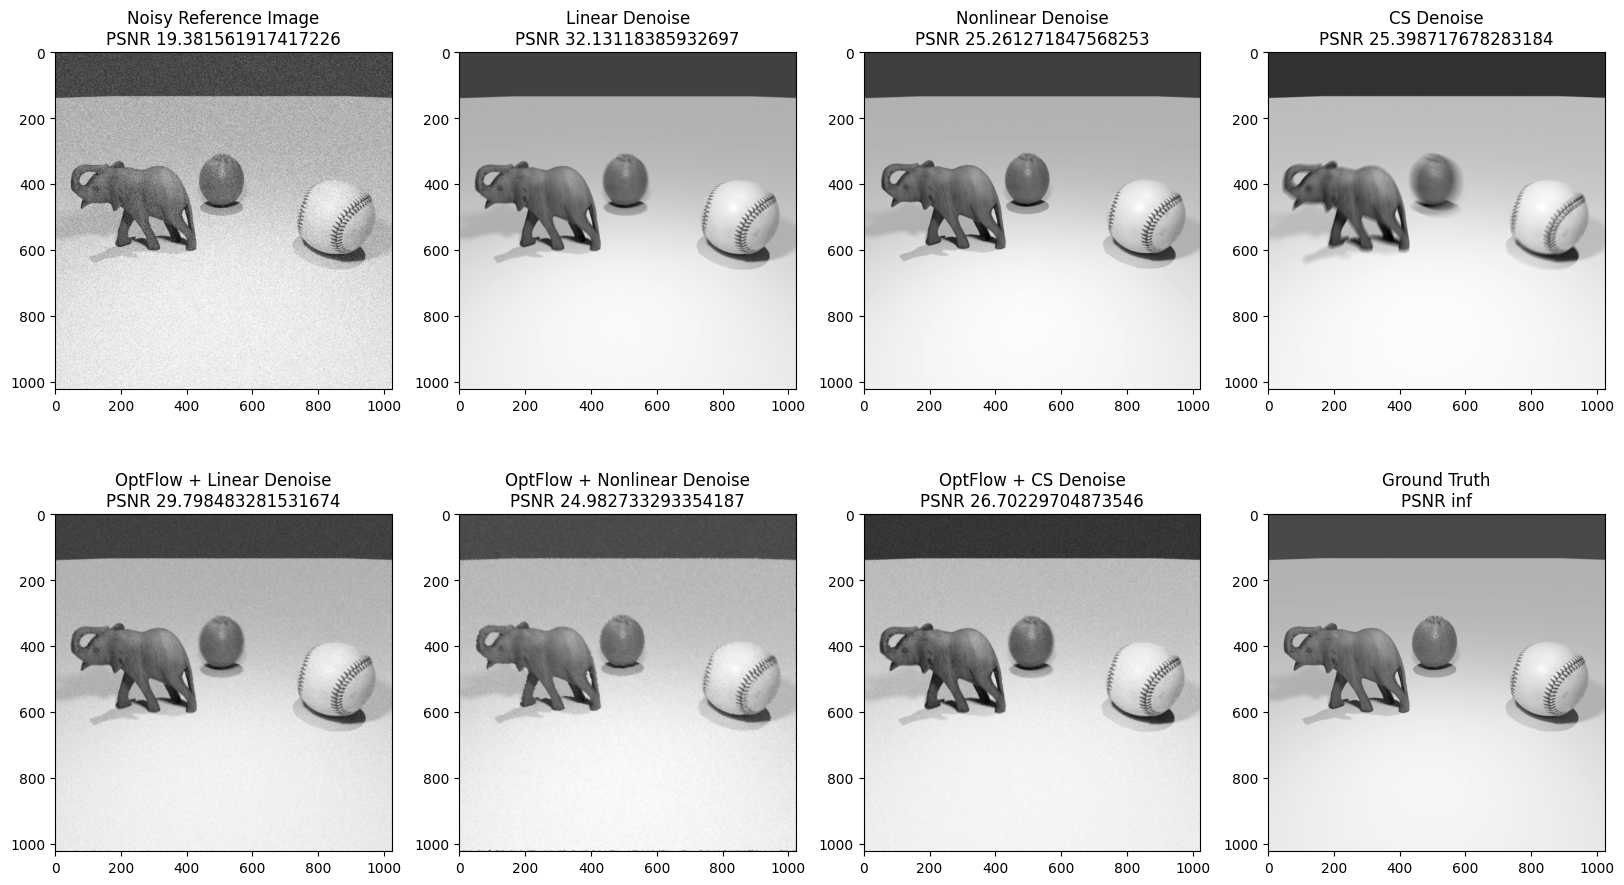

In [39]:
cmap_color = 'gray'#'viridis'

fig, axs = plt.subplots(2, 4,figsize=(20,11))
# fig.suptitle('Denoising Methods')
axs[0,0].imshow(Z_noise[ref_idx], cmap=cmap_color)
axs[0,0].set_title('Noisy Reference Image' + '\nPSNR ' + str(psnr(normalize_2D(X_gt),
                                                              normalize_2D(Z_noise[ref_idx]))))
axs[0,1].imshow(X_avg, cmap=cmap_color)
axs[0,1].set_title('Linear Denoise'+ '\nPSNR ' + str(psnr(normalize_2D(X_gt),
                                                              normalize_2D(X_avg))))
axs[0,2].imshow(X_med, cmap=cmap_color)
axs[0,2].set_title('Nonlinear Denoise'+ '\nPSNR ' + str(psnr(normalize_2D(X_gt),
                                                              normalize_2D(X_med))))
axs[0,3].imshow(X_cs, cmap=cmap_color)
axs[0,3].set_title('CS Denoise'+ '\nPSNR ' + str(psnr(normalize_2D(X_gt),
                                                              normalize_2D(X_cs))))

axs[1,0].imshow(X_avg_reg, cmap=cmap_color)
axs[1,0].set_title('OptFlow + Linear Denoise'+ '\nPSNR ' + str(psnr(normalize_2D(X_gt),
                                                              normalize_2D(X_avg_reg))))
axs[1,1].imshow(X_med_reg, cmap=cmap_color)
axs[1,1].set_title('OptFlow + Nonlinear Denoise'+ '\nPSNR ' + str(psnr(normalize_2D(X_gt),
                                                              normalize_2D(X_med_reg))))
axs[1,2].imshow(X_cs_reg, cmap=cmap_color)
axs[1,2].set_title('OptFlow + CS Denoise'+ '\nPSNR ' + str(psnr(normalize_2D(X_gt),
                                                              normalize_2D(X_cs_reg))))
axs[1,3].imshow(X_gt, cmap=cmap_color)
axs[1,3].set_title('Ground Truth'+ '\nPSNR ' + str(psnr(normalize_2D(X_gt),
                                                              normalize_2D(X_gt))))